<h1><strong><u>K-Nearest Neighbors Model</u></strong></h1>

<h2><strong><u>Data Preparation</u></strong></h2>

In [35]:
%%capture
%run DataPreparation.ipynb

<h2><strong><u>KNN Model Selection</u></strong></h2>

<h3><strong><u>Validation Curves</u></strong></h3>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ................................clf__n_neighbors=21; total time=  12.0s
[CV] END ................................clf__n_neighbors=11; total time=  13.9s
[CV] END ................................clf__n_neighbors=71; total time=  13.9s
[CV] END .................................clf__n_neighbors=1; total time=  12.1s
[CV] END ................................clf__n_neighbors=31; total time=  14.0s
[CV] END ................................clf__n_neighbors=61; total time=  12.0s
[CV] END ................................clf__n_neighbors=51; total time=  12.0s
[CV] END ...............................clf__n_neighbors=101; total time=   7.5s
[CV] END ................................clf__n_neighbors=91; total time=   7.7s
[CV] END ................................clf__n_neighbors=81; total time=   4.9s
[CV] END ................................clf__n_neighbors=41; total time=  13.9s
[CV] END ...............................clf__n_neighbors=111; total time=  11.8s
[CV] END ...................

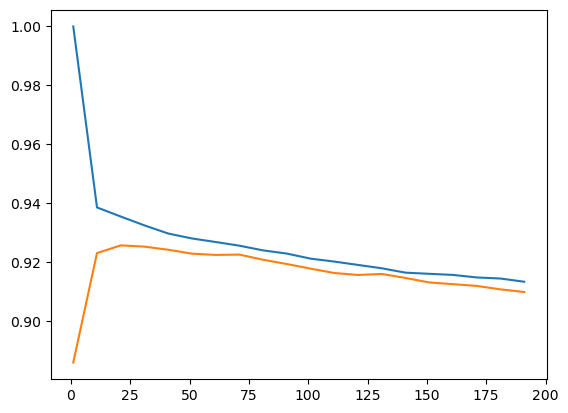

In [37]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", KNeighborsClassifier())
    ]
)
neighbors = list(range(1, 201, 10))
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__n_neighbors",
                                                   param_range=neighbors,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(neighbors, train_scores_mean)
plt.plot(neighbors, validation_scores_mean)

<h3><strong><u>Cross Validation Testing</u></strong></h3>

In [38]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", KNeighborsClassifier())
    ]
)
param_grid = {
    "clf__n_neighbors": [23, 25, 27, 29],
}

model = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
model.fit(X_train, y_train)
knn_classifier = model.best_estimator_
model.best_params_

def knn_model():
    return knn_classifier

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 3/5] END ...............clf__n_neighbors=23;, score=0.924 total time=   9.2s
[CV 2/5] END ...............clf__n_neighbors=23;, score=0.928 total time=   9.7s
[CV 5/5] END ...............clf__n_neighbors=25;, score=0.928 total time=   4.5s
[CV 4/5] END ...............clf__n_neighbors=25;, score=0.921 total time=   5.4s
[CV 1/5] END ...............clf__n_neighbors=25;, score=0.924 total time=  16.6s
[CV 5/5] END ...............clf__n_neighbors=23;, score=0.929 total time=  16.6s
[CV 2/5] END ...............clf__n_neighbors=25;, score=0.926 total time=  16.6s
[CV 4/5] END ...............clf__n_neighbors=23;, score=0.922 total time=  17.3s
[CV 1/5] END ...............clf__n_neighbors=23;, score=0.923 total time=  17.3s
[CV 3/5] END ...............clf__n_neighbors=25;, score=0.927 total time=  17.2s
[CV 1/5] END ...............clf__n_neighbors=27;, score=0.924 total time=   3.7s
[CV 2/5] END ...............clf__n_neighbors=27;,

<h4><strong><u>Findings From 'Model Selection' Section</u></strong></h4>
The scoring metrics that I used for the Grid Search cross-validation test was accuracy since the dataset is balanced. I chose to validate for a wide range of neighbors so that I could see the overall test/validation score trend with the increase of neighbors. It was pretty clear to see that somewhere between 20-25 is the best neighbor count. The Grid Search cross-validation resulted in a neighbor count of 23 for the model.

<h2><strong><u>Model Evaluation</u></strong></h2>

In [39]:
precision = make_scorer(precision_score, greater_is_better=True, pos_label='clickbait')
recall = make_scorer(recall_score, greater_is_better=True, pos_label='clickbait')
npv = make_scorer(precision_score, greater_is_better=True, pos_label='non clickbait')
specificity = make_scorer(recall_score, greater_is_better=True, pos_label='non clickbait')

In [40]:
clf_metrics = {'Accuracy': 'accuracy', 'Precision': precision, 'Recall': recall, 'Negative Predictive Value': npv, 'Specificity': specificity}

<h3><strong><u>Learning Curves</u></strong></h3>

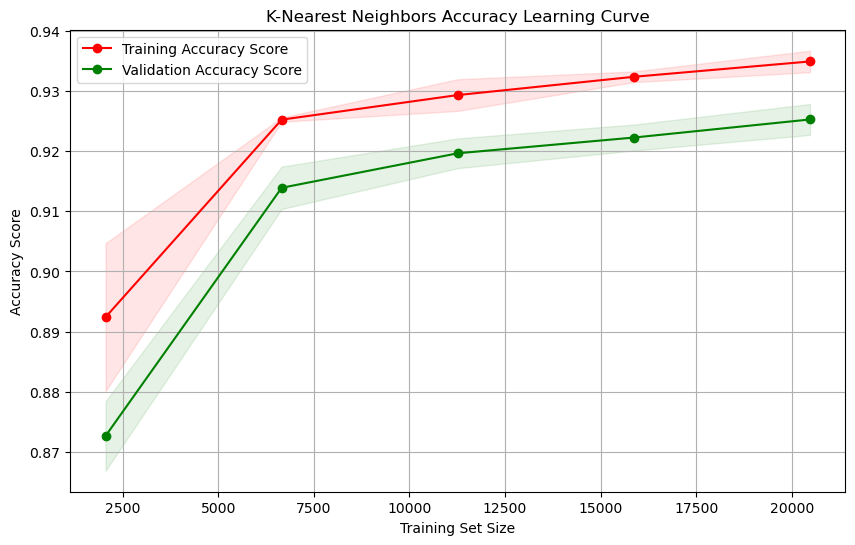

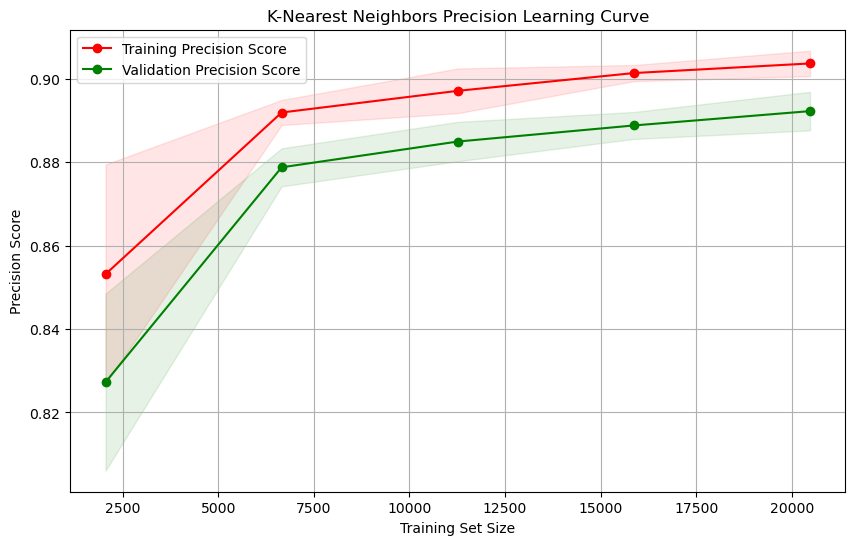

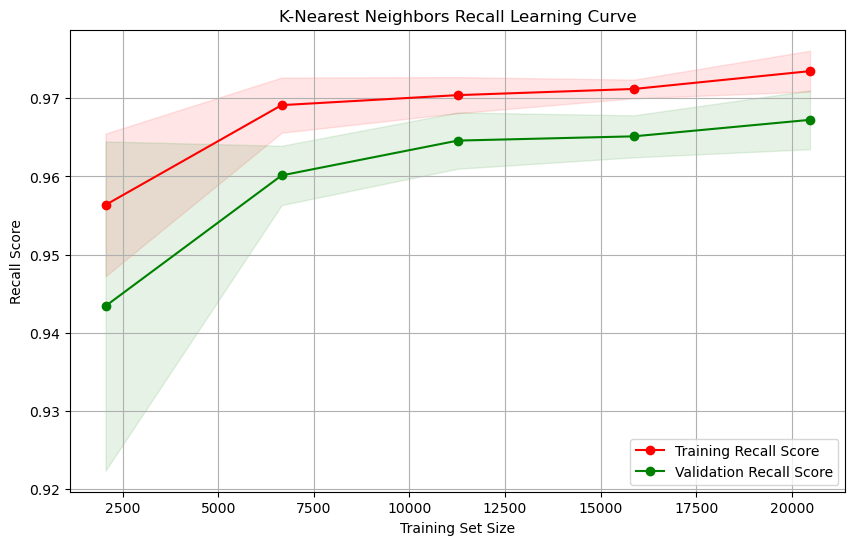

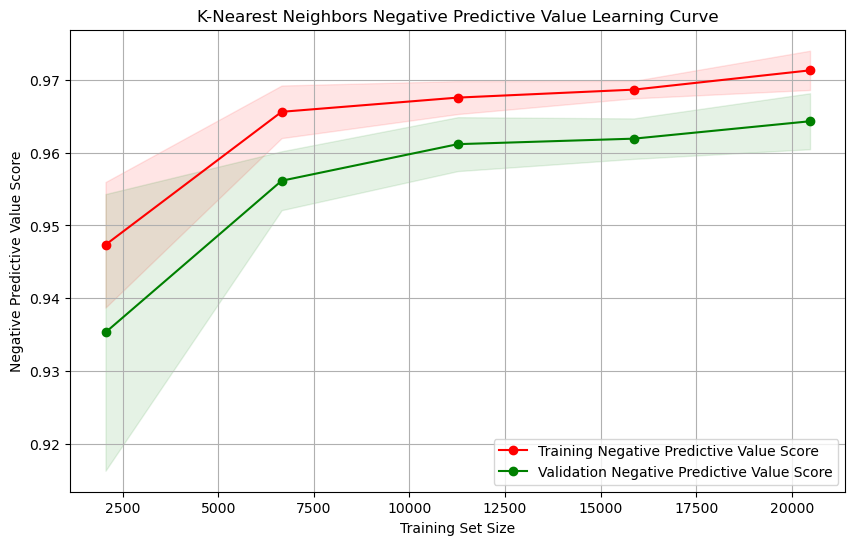

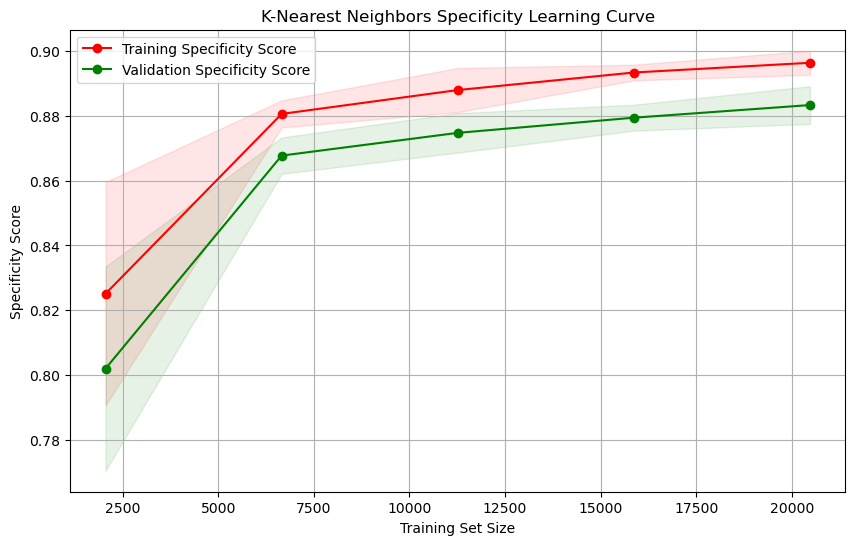

In [41]:
for key, value in clf_metrics.items():
    knn_train_sizes, knn_train_scores, knn_validation_scores = learning_curve(
        knn_classifier,
        X_train,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    knn_train_scores_mean = np.mean(knn_train_scores, axis=1)
    knn_train_scores_std = np.std(knn_train_scores, axis=1)
    knn_validation_scores_mean = np.mean(knn_validation_scores, axis=1)
    knn_validation_scores_std = np.std(knn_validation_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title(f"K-Nearest Neighbors {key} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{key} Score")
    plt.grid()

    plt.fill_between(knn_train_sizes, knn_train_scores_mean - knn_train_scores_std,
                    knn_train_scores_mean + knn_train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(knn_train_sizes, knn_validation_scores_mean - knn_validation_scores_std,
                    knn_validation_scores_mean + knn_validation_scores_std, alpha=0.1,
                    color="g")
    plt.plot(knn_train_sizes, knn_train_scores_mean, 'o-', color="r",
                label=f"Training {key} Score")
    plt.plot(knn_train_sizes, knn_validation_scores_mean, 'o-', color="g",
                label=f"Validation {key} Score")

    plt.legend(loc="best")
    plt.show()

<h3><strong><u>Evaluation Metrics</u></strong></h3>

In [42]:
for key, value in clf_metrics.items():
    print(f"{key}")
    nb_training_values = cross_val_score(knn_classifier, X_train, y=y_train, scoring=value, cv=5)
    print("CV Training Scores: ", nb_training_values)
    np_nb_training_values = np.array(nb_training_values)
    average = np.mean(np_nb_training_values)
    stDev = np.std(np_nb_training_values)
    print(f"Training Average and Standard Error: ", "{:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

Accuracy
CV Training Scores:  [0.9234375  0.92753906 0.92382812 0.92246094 0.92910156]
Training Average and Standard Error:  0.93% ± 0.26% 

Precision
CV Training Scores:  [0.88904847 0.89179506 0.89389535 0.88658318 0.90010937]
Training Average and Standard Error:  0.89% ± 0.46% 

Recall
CV Training Scores:  [0.96756546 0.9730258  0.96168882 0.96872557 0.96520719]
Training Average and Standard Error:  0.97% ± 0.38% 

Negative Predictive Value
CV Training Scores:  [0.96445396 0.97037355 0.95861486 0.9655914  0.96255785]
Training Average and Standard Error:  0.96% ± 0.38% 

Specificity
CV Training Scores:  [0.87934401 0.88212334 0.88602654 0.87626854 0.8930523 ]
Training Average and Standard Error:  0.88% ± 0.58% 



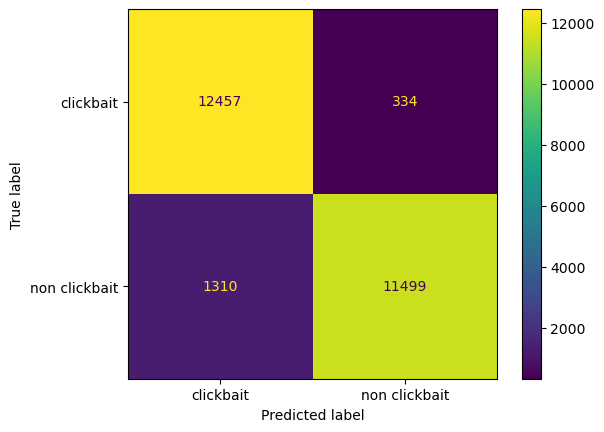

In [43]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_classifier, X_train, y_train, labels=['clickbait', 'non clickbait'])

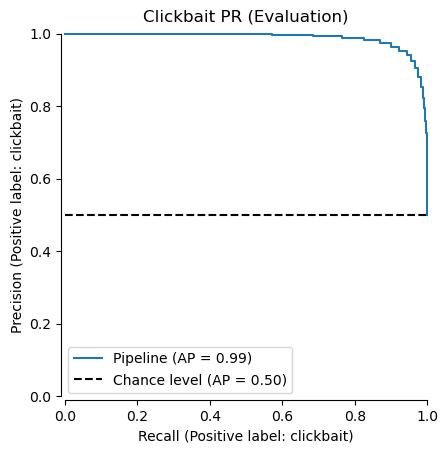

In [44]:
disp = PrecisionRecallDisplay.from_estimator(knn_classifier, X_train, y_train, pos_label="clickbait", plot_chance_level=True, despine=True)
disp.ax_.set_title("Clickbait PR (Evaluation)")
plt.show()

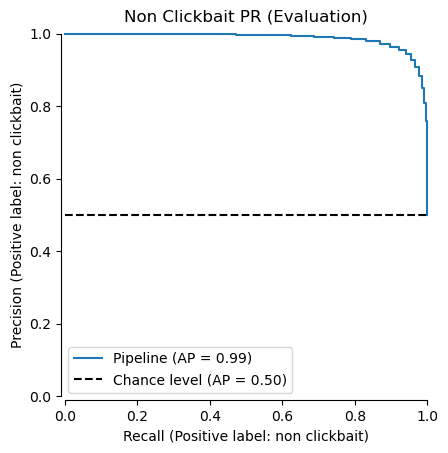

In [45]:
disp = PrecisionRecallDisplay.from_estimator(knn_classifier, X_train, y_train, pos_label="non clickbait", plot_chance_level=True, despine=True)
disp.ax_.set_title("Non Clickbait PR (Evaluation)")
plt.show()

<h4><strong><u>Findings From 'Model Evaluation' Phase</u></strong></h4>
In the evaluation of my selected model, I found positive results for all evaluation methods. The learning curves yielded good results and the 'cross_val_score' function evaluation results reinforced the learning curve values. In addition, the Confusion Matrix helps show that the model performed well on the training data with minimal False Negatives and False Positives. Finally, The Precision-Recall plots display a good curves that moves to the top-right corner of the plot indicating a good classifier model. As a result, I will move forward with this model to the 'Model Testing' section.

<h2><strong><u>Model Testing</u></strong></h2>

<h3><strong><u>Performance Metrics</u></strong></h3>

In [46]:
for key, value in clf_metrics.items():
    print(f"{key}")
    log_test_values = cross_val_score(knn_classifier, X_test, y=y_test, scoring=value, cv=5)
    print(f"CV test Scores: ", log_test_values)
    np_log_test_values = np.array(log_test_values)
    average = np.mean(np_log_test_values)
    stDev = np.std(np_log_test_values)
    print(f"Average and Standard Error: ", "{:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

Accuracy
CV test Scores:  [0.90859375 0.9046875  0.91875    0.90703125 0.91328125]
Average and Standard Error:  0.91% ± 0.50% 

Precision
CV test Scores:  [0.88209607 0.87142857 0.89675516 0.87073864 0.88294798]
Average and Standard Error:  0.88% ± 0.95% 

Recall
CV test Scores:  [0.94392523 0.95015576 0.9470405  0.95631825 0.95319813]
Average and Standard Error:  0.95% ± 0.44% 

Negative Predictive Value
CV test Scores:  [0.93929174 0.94482759 0.94352159 0.95138889 0.94897959]
Average and Standard Error:  0.95% ± 0.42% 

Specificity
CV test Scores:  [0.87304075 0.85893417 0.89028213 0.85758998 0.87323944]
Average and Standard Error:  0.87% ± 1.19% 



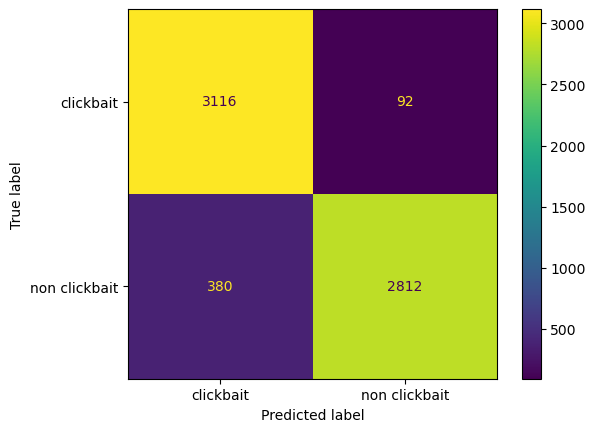

In [47]:
#Testing Confusion Matrix
knn_test_predictions = knn_classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, knn_test_predictions, labels=['clickbait', 'non clickbait'])

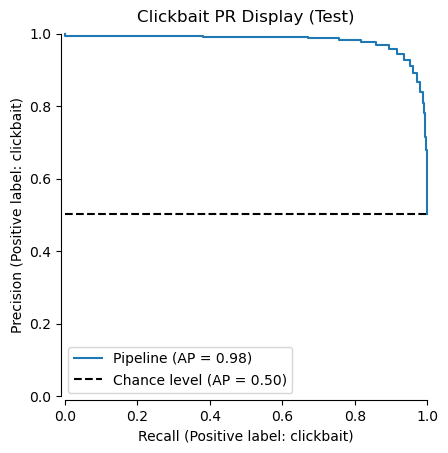

In [48]:
disp = PrecisionRecallDisplay.from_estimator(knn_classifier, X_test, y_test, pos_label="clickbait", plot_chance_level=True, despine=True)
disp.ax_.set_title("Clickbait PR Display (Test)")
plt.show()

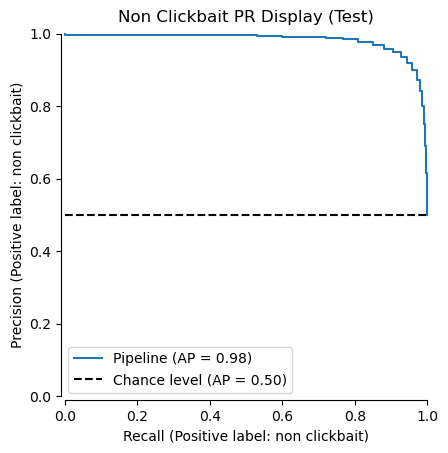

In [50]:
disp = PrecisionRecallDisplay.from_estimator(knn_classifier, X_test, y_test, pos_label="non clickbait", plot_chance_level=True, despine=True)
disp.ax_.set_title("Non Clickbait PR Display (Test)")
plt.show()

<h4><strong><u>Findings From 'Model Testing' Phase</u></strong></h4>
In the testing phase of my selected model, I found that the testing results were good and in keeping with my results from the 'Model Evaluation' section. The 'cross_val_score' function evaluation results, Confusion Matrix display, and PR displays were all in keeping with the results from the 'Model Evaluation' section. 

<h2><strong><u>Conclusion</u></strong></h2>
Considering the results of the experiment, I believe this model can used for clickbait classification.